In [82]:
import time as tm
import numpy as np

import matplotlib
matplotlib.rcParams['text.usetex'] = True

from scipy.special import comb
from scipy.misc import derivative
from scipy import integrate, interpolate

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
import utilities_simple as utilities
from chainconsumer import ChainConsumer

In [83]:
### Define all the constants 
c      = 299792.458           #km/s
GN     = 6.674e-11     #m^3/kg/s^2
Msolar = 1.989e30  # kg
Mpc    = 3.086e19     # km

cosmo_params = {
     'OmegaM' : 0.2999,
     'OmegaDE': 0.7,
     'OmegaR' : 1.e-4,
     'h'     : 0.7,
 }

#GW150914 parameters
m1   = 36       #solarmass
m2   = 29

Dl   = 410      #Mpc
zem  = 0.09

time = 2*365*24*3600    # time before merger in sec
tc   = 0
psic = 0

In [68]:
#Read in and interpolate LIGO and LISA PSDs.
ligo_asd    = np.genfromtxt('../data/lalsimulation_lib_LIGO-T1800545-v1-aLIGO_175Mpc.txt')
LISA_strain = np.loadtxt('../data/LISA_strain.txt')

ligo_interp = interpolate.interp1d(ligo_asd[:,0],ligo_asd[:,1])
lisa_interp = interpolate.interp1d(LISA_strain[:,0], LISA_strain[:,3])

In [487]:
def numerical_derivative(func, par, dx, verbose=False):
    
    ratio = 1e8

    while ratio > 5e-2:
        d1    = derivative(func, par, dx=dx/2, order=5)
        d2    = derivative(func, par, dx=dx *2, order=5)
        
        ld1   = len(d1)
        prod  = d1 *d2
        
        d1    = d1[prod != 0]
        d2    = d2[prod != 0]
        
        r_vec = np.abs( (d1 -d2)/np.mean((d1,d2), axis=0) )
        
        if len(r_vec) < int(ld1/3):
            ratio = 1e8
        else:
            ratio = np.mean(r_vec)
        
        dx *= .5       
               
    if dx < 1e-15:
        print(par, dx)
        raise ValueError('No convergence')
               
    return derivative(func, par, dx=dx*2)

In [488]:
# Define function to return covariance matrix for chosen waveform.

def Fisher_det(farr, pars, psd, cosmo_params, which_wf='GR', MG_flag=False, width=0, distcorr=True):
    t0 = tm.perf_counter()
    if which_wf=='GR':
        waveform = utilities.waveform
    elif which_wf=='EFT':
        waveform = utilities.waveform_delta(cT_type='EFT').h_Delta_exact
    elif which_wf=='step':
        waveform = utilities.waveform_delta(cT_type='step', width=width).h_Delta_exact
    
    if distcorr==False:
        hf = waveform(farr, pars, cosmo_params,False)
    else:      
        hf = waveform(farr, pars, cosmo_params)
    
    # Function to compute numerical derivatives w.r.t. lnM
    h_dlnMz_to_der = lambda lnMz_func: waveform(farr, [lnMz_func, pars[1], pars[2], pars[3], pars[4], pars[5], pars[6]], cosmo_params)

    # Function to compute numerical derivatives w.r.t. lneta
    h_dlneta_to_der = lambda lneta_func: waveform(farr, [pars[0], lneta_func, pars[2], pars[3], pars[4], pars[5], pars[6]], cosmo_params)
        
    # Function to compute numerical derivatives w.r.t. lnz
    h_dlnz_to_der = lambda lnz_func: waveform(farr, [pars[0], pars[1], lnz_func, pars[3], pars[4], pars[5], pars[6]], cosmo_params)
    
    # Function to compute numerical derivatives w.r.t. lnz
    h_dc0_to_der = lambda c0_func: waveform(farr, [pars[0], pars[1], pars[2], pars[3], pars[4], c0_func, pars[6]], cosmo_params)
    
    # Analytical derivetives w.r.t. tc and psic
    dh_dtc      = 2.j*np.pi*farr*waveform(farr, pars, cosmo_params)
    dh_dpsic    = -1.j*waveform(farr, pars, cosmo_params)
    
    to_der      = [h_dlneta_to_der, h_dlnMz_to_der, h_dlnz_to_der, dh_dtc, dh_dpsic, h_dc0_to_der]
    derivatives = []
    verbose     = False
    
    for i in range(0, len(to_der)):
        print('- Working on index', i)
        dx = np.abs(.3 *pars[i]) if pars[i] != 0 else 1e-1
        
        if i == 3 or i == 4:
            derivatives.append(to_der[i])
        elif i == 5:
            if MG_flag:
                derivatives.append(numerical_derivative(to_der[i], pars[i], dx=dx))
                
        else:
            if i == 0 or i ==2:
                dx = 1e-2
            elif i ==1:
                dx = 1e-5            
            derivatives.append(numerical_derivative(to_der[i], pars[i], dx=dx, verbose=verbose))
    
    derivatives   = derivatives[:2][::-1] + derivatives[2:]
    Fisher_matrix = np.zeros((len(derivatives),len(derivatives)))

    for i in range(0, len(derivatives)):
        for j in range(0,i +1):
            Fisher_matrix[i,j] = utilities.scalar_product(derivatives[i], derivatives[j], psd, farr)
            Fisher_matrix[j,i] = Fisher_matrix[i,j]
    
    print('This took %.2f seconds' % (tm.perf_counter() -t0) )
    connum = np.linalg.cond(Fisher_matrix)
    print('condition number (div by 1e15)',connum/1.e15)

    return Fisher_matrix

In [479]:
# Def plotting function. Define figure first with:
    # fig = plt.figure(figsize=(20,20))
    # gs = gridspec.GridSpec(nparams-1, nparams-1, hspace=0, wspace=0)

def add_fisher_plots(covmat,fid_vals,labels,leg_label,colour):
    alpha = 1.52            #For 1 sigma

    nparams = len(fid_vals)

    for i in range(0,nparams-1):
        for j in range(1+i,nparams):

            ax = plt.subplot(gs[i+(nparams-1)*(j-1)])
            axis_swap = False       # Default is false.

            # Fisher forecast
            a,b, theta_deg = utilities.ellipse_para(covmat[i,i], covmat[j,j], covmat[i,j]) 
            a1sig, b1sig = alpha*a, alpha*b
            
            if (covmat[j,j]>covmat[i,i]):
                theta_deg +=90
                axis_swap = True
            
            rho = covmat[i,j] / np.sqrt(covmat[i,i]* covmat[j,j])

            contour = Ellipse((fid_vals[i],fid_vals[j]), 2.*a1sig, 2.*b1sig, theta_deg, fill=False, color=colour,label=r'$\rho=%.3f$'%rho)

            ax.add_patch(contour)

            if j==(nparams-1):
                ax.set_xlabel(labels[i], fontsize=20)
                plt.xticks(fontsize=20)
            else:
                ax.set_xticklabels([], fontsize=20)

            if i==0:    
                ax.set_ylabel(labels[j], fontsize=20)
                plt.yticks(fontsize=20)
            else:
                ax.set_yticklabels([], fontsize=20)
            
            space_fac = 1.5    #just to pad some white space around the ellipses

            ax.set_xlim(fid_vals[i]-space_fac*alpha*np.sqrt(covmat[i,i]), fid_vals[i]+space_fac*alpha*np.sqrt(covmat[i,i]))
            ax.set_ylim(fid_vals[j]-space_fac*alpha*np.sqrt(covmat[j,j]), fid_vals[j]+space_fac*alpha*np.sqrt(covmat[j,j]))
            
            ax.legend(fontsize=5, loc=2)
       

In [480]:
# Get mass quantities
m_eff = m1*m2/(m1+m2)
Ms = m_eff**(3./5) * (m1+m2)**(2./5)     # source chirp mass in solarmass
eta = ((m1+m2)/Ms)**(-5./3)

Dl_s = Dl*Mpc/c        # Dl in sec

Ms_s = Ms * Msolar * GN / (c*1.e3)**3.       # source chirp mass in sec
Mtot_s = (m1+m2) * Msolar * GN / (c*1.e3)**3.

# Get frequency ranges for inspiral and plots
f_start = (5*Ms_s/256/time)**(3./8) / np.pi/Ms_s      # starting frequency at the time before merger
f_cut = utilities.get_freq(Mtot_s, eta, "cut")       # End of IMR template
fc = utilities.inspiral_fc(Mtot_s)
farr = np.logspace(np.log10(f_start),np.log10(fc),num=500)  #inspiral range only
f_plot = np.logspace(np.log10(f_start),np.log10(f_cut),num=500)     # full IMR waveform

Dl_arr = np.array([Dl_s]*len(farr))

In [481]:
print('eta',eta)
print('fc',fc)

eta 0.24710059171597634
fc 67.63181124855085


In [482]:
#Waveforms for inspiral and IMR, in GR
pars_GR = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 0, 0]

h_GR = utilities.waveform(farr, pars_GR, cosmo_params)
h_plot = utilities.waveform(f_plot, pars_GR, cosmo_params)

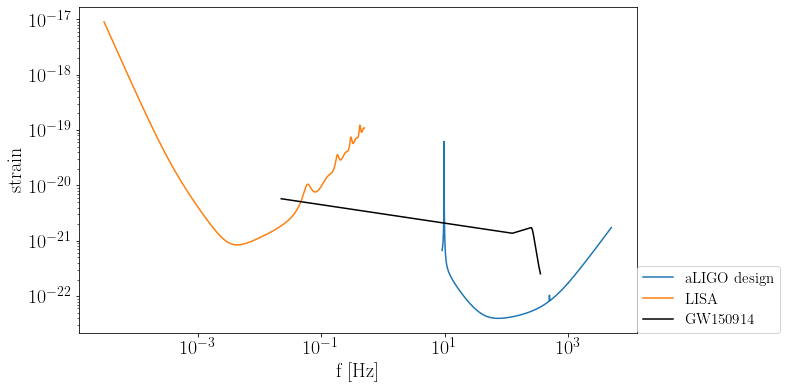

In [483]:
# Plot full IMR GR signal
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(f_plot, np.abs(f_plot*h_plot), color='k', label='GW150914')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15, loc=(1,0))

In [484]:
# Get waveform segments in LISA and LIGO ranges only.
farr_ligo = np.logspace(np.log10(ligo_asd[0,0]),np.log10(fc),num=500)
farr_lisa = np.logspace(np.log10(f_start),np.log10(LISA_strain[-1,0]),num=500)

ligo_psd = ligo_interp(farr_ligo)**2
lisa_psd = lisa_interp(farr_lisa)

h_GR_ligo = utilities.waveform(farr_ligo, pars_GR, cosmo_params)
h_GR_lisa = utilities.waveform(farr_lisa, pars_GR, cosmo_params)


In [485]:
# SNR in LISA and LIGO
SNR_ligo_sq = utilities.scalar_product(h_GR_ligo, h_GR_ligo, ligo_psd, farr_ligo)
SNR_ligo = np.sqrt(SNR_ligo_sq)

SNR_lisa_sq = utilities.scalar_product(h_GR_lisa, h_GR_lisa, lisa_psd, farr_lisa)
SNR_lisa = np.sqrt(SNR_lisa_sq)

print('design LIGO SNR')
print(SNR_ligo)
print('LISA SNR')
print(SNR_lisa)

design LIGO SNR
65.53220995174958
LISA SNR
3.4325121616962133


# GR Constraints

In [489]:
fisher_ligo = Fisher_det(farr_ligo, pars_GR, ligo_psd, cosmo_params, which_wf='GR')
cov_matrix_ligo = np.linalg.inv(fisher_ligo)
pconstraints_ligo = np.sqrt(np.diag(cov_matrix_ligo))

print('LIGO GR constraints')
print(pconstraints_ligo)

- Working on index 0
- Working on index 1
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5
This took 3.99 seconds
condition number (div by 1e15) 4.538859984118322e-08
LIGO GR constraints
[6.99414528e-06 3.26782903e-04 1.43873748e-02 1.68824195e-04
 4.70267011e-02]


In [490]:
fisher_ligo

array([[ 2.05235274e+10, -1.62863036e+07,  3.34122207e+05,
         1.95267349e+07, -1.80141202e+05],
       [-1.62863036e+07,  9.37742551e+06,  1.44512293e+02,
        -4.38050575e+04,  1.14387050e+02],
       [ 3.34122207e+05,  1.44512293e+02,  4.83646365e+03,
        -1.15308257e-10,  2.40245257e-13],
       [ 1.95267349e+07, -4.38050575e+04, -1.15308257e-10,
         3.33114490e+08, -1.13124342e+06],
       [-1.80141202e+05,  1.14387050e+02,  2.40245257e-13,
        -1.13124342e+06,  4.29447054e+03]])

In [356]:
fisher_lisa = Fisher_det(farr_lisa, pars_GR, lisa_psd, cosmo_params, which_wf='GR') 
cov_matrix_lisa = np.linalg.inv(fisher_lisa)
pconstraints_lisa = np.sqrt(np.diag(cov_matrix_lisa))

print('LISA GR constraints')
print(pconstraints_lisa)

This took 6.36 seconds
condition number (div by 1e15) 0.0902702756025596
LISA GR constraints
[2.66652528e-07 6.42801426e-06 2.68733033e-01 2.45748279e+00
 5.98372870e-01]


In [357]:
fisher_lisa

array([[ 1.42928355e+13, -5.85198911e+10,  1.06675119e+04,
        -1.00026034e+05,  7.90534965e+05],
       [-5.85198911e+10,  2.45118853e+10,  1.58613456e+04,
        -3.14466764e+03,  1.92798075e+04],
       [ 1.06675119e+04,  1.58613456e+04,  1.38575248e+01,
        -1.04691388e-17,  6.71873728e-18],
       [-1.00026034e+05, -3.14466764e+03, -1.04691388e-17,
         6.95922276e-01, -2.49879922e+00],
       [ 7.90534965e+05,  1.92798075e+04,  6.71873728e-18,
        -2.49879922e+00,  1.17821397e+01]])

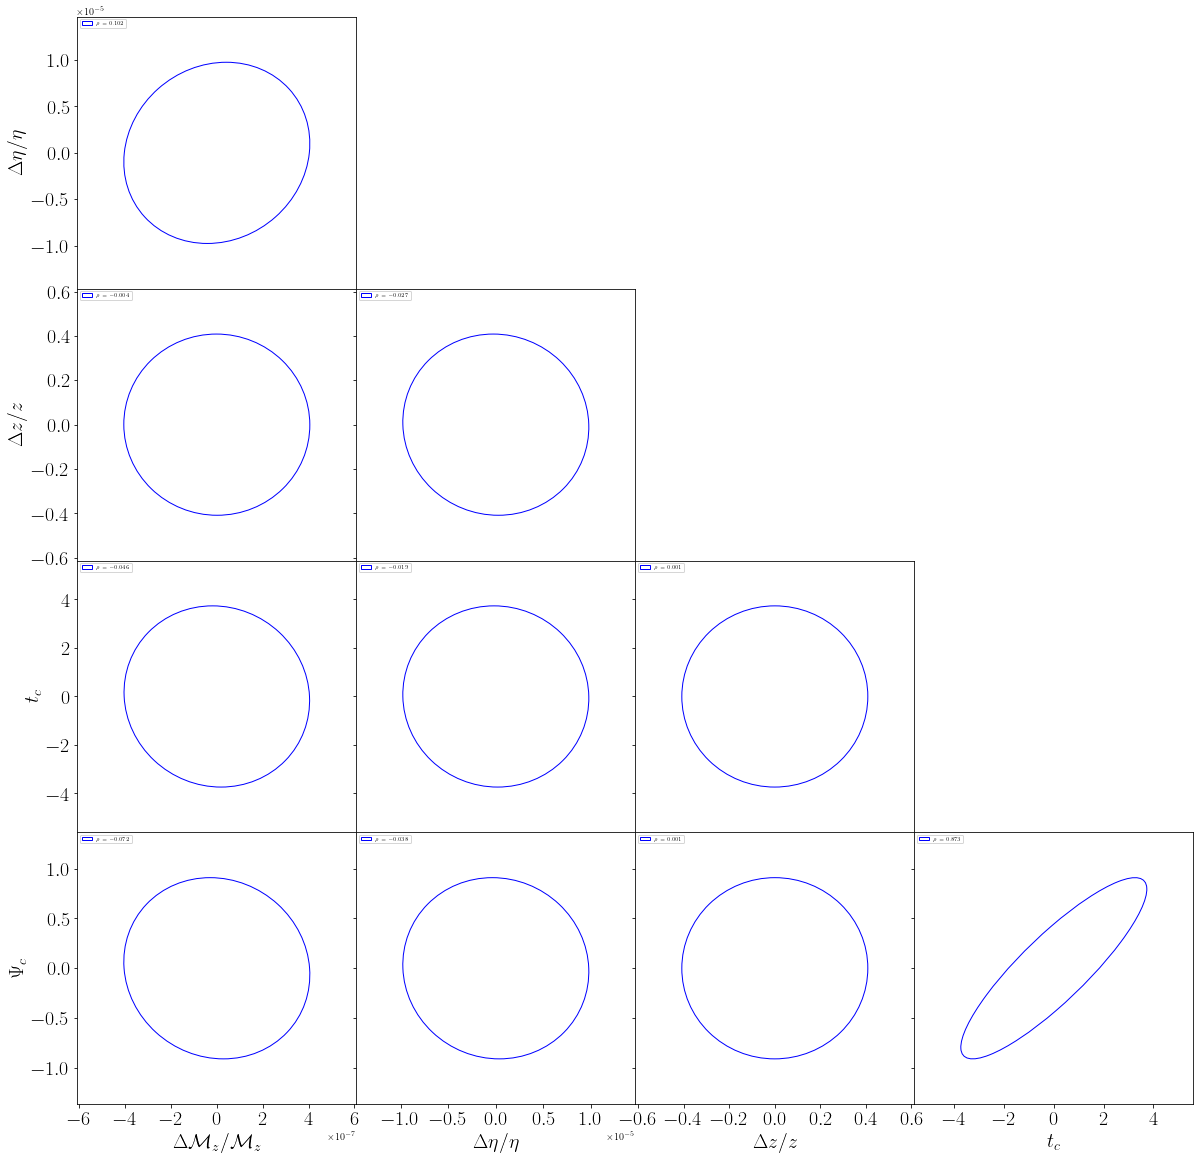

In [358]:
#make Fisher plot for LISA constraints
labels_GR = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$']
fid_vals_GR = [0,0,0,0,0]

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(len(fid_vals_GR)-1, len(fid_vals_GR)-1, hspace=0, wspace=0)

add_fisher_plots(cov_matrix_lisa,fid_vals_GR,labels_GR,'GR LISA','b')

In [359]:
label_GR = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$']
fid_vals_GR = [0,0,0,0,0]

data_ligo = np.random.multivariate_normal(fid_vals_GR, cov_matrix_ligo, size=10000)
data_lisa = np.random.multivariate_normal(fid_vals_GR, cov_matrix_lisa, size=10000)

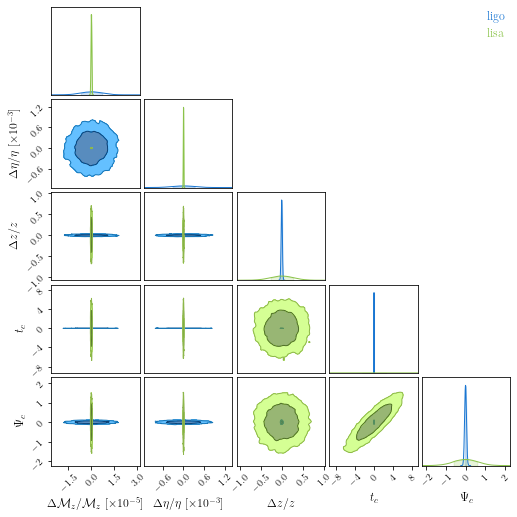

In [360]:
cc = ChainConsumer()
cc.add_chain(data_ligo, bins=30, smooth=True, parameters=label_GR, name='ligo');
cc.add_chain(data_lisa, bins=30, smooth=True, parameters=label_GR,name='lisa');
cc.plotter.plot();

# Step function

In [361]:
# Set parameters for step
fstar = 0.8
c0 = 0.9
w1 = 0.5


In [362]:
# Evaluate and plot Delta
cT_step_fo_w1 = utilities.cT_step(farr, fstar, c0, w1)
cT_step_fs_w1 = utilities.cT_step(farr*(1+zem), fstar, c0, w1)
Delta_step_w1 = 1-cT_step_fo_w1/cT_step_fs_w1

Text(0, 0.5, '$\\Delta$')

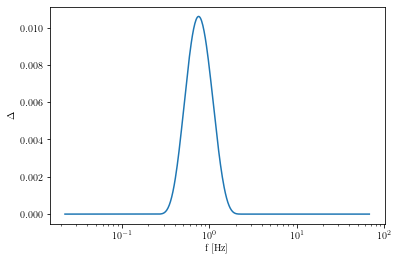

In [363]:
plt.semilogx(farr, Delta_step_w1)
plt.xlabel('f [Hz]')
plt.ylabel(r'$\Delta$')

In [364]:
# Set parameters for runs and evaluate
pars_step = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, c0, fstar]
pars_step_fid = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 1., fstar]

# For plotting only
h_Delta_step_w1 = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr, pars_step, cosmo_params)
h_Delta_step_w1_fid = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr, pars_step_fid, cosmo_params)
h_Delta_step_w1_fid_nodist = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr, pars_step_fid, cosmo_params,dist_corr=False)

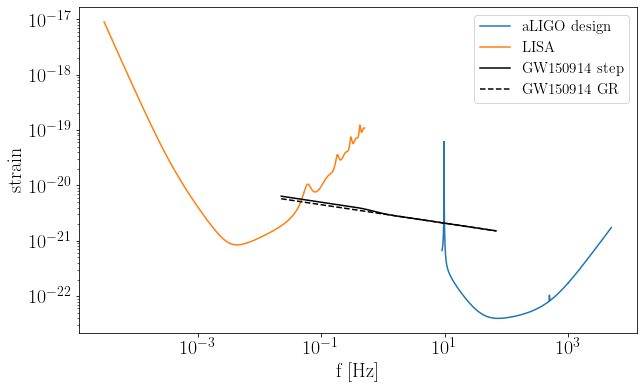

In [365]:
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(farr, np.abs(farr*h_Delta_step_w1), color='k', label='GW150914 step')
plt.loglog(farr, np.abs(farr*h_GR), color='k', label='GW150914 GR', linestyle='--')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
# plt.savefig('../plots/amp_psd_step.pdf')

In [366]:
mask_ligo = (farr>ligo_asd[0,0]) & (farr<=ligo_asd[-1,0])
mask_lisa = (farr>LISA_strain[0,0]) & (farr<=LISA_strain[-1,0])

ligo_psd = ligo_interp(farr[mask_ligo])**2
lisa_psd = lisa_interp(farr[mask_lisa])

In [445]:
# SNR for fiducial and non-fiducial models
SNR_ligo_sq = utilities.scalar_product(h_Delta_step_w1[mask_ligo], h_Delta_step_w1[mask_ligo], ligo_psd, farr[mask_ligo])
SNR_ligo_sq_fid = utilities.scalar_product(h_Delta_step_w1_fid[mask_ligo], h_Delta_step_w1_fid[mask_ligo], ligo_psd, farr[mask_ligo])
SNR_ligo_step = np.sqrt(SNR_ligo_sq)
SNR_ligo_step_fid = np.sqrt(SNR_ligo_sq_fid)

SNR_lisa_sq = utilities.scalar_product(h_Delta_step_w1[mask_lisa], h_Delta_step_w1[mask_lisa], lisa_psd, farr[mask_lisa])
SNR_lisa_sq_fid = utilities.scalar_product(h_Delta_step_w1_fid[mask_lisa], h_Delta_step_w1_fid[mask_lisa], lisa_psd, farr[mask_lisa])
SNR_lisa_step = np.sqrt(SNR_lisa_sq)
SNR_lisa_step_fid = np.sqrt(SNR_lisa_sq_fid)

print('LIGO SNR, mod and fiducial')
print(SNR_ligo_step,SNR_ligo_step_fid)
print('LISA SNR, mod and fiducial')
print(SNR_lisa_step,SNR_lisa_step_fid)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 500

- Working on index 0
- Working on index 1
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5


/home/mauropieroni/Desktop/My_projects/multiband_MG/code/utilities_simple.py:404: RuntimeWarning: invalid value encountered in true_divide
  return 1-cT_step_fo/cT_step_fs
/home/mauropieroni/Desktop/My_projects/multiband_MG/code/utilities_simple.py:345: RuntimeWarning: divide by zero encountered in true_divide
  dl_MG = dl_GR / np.sqrt(1-Delta) * cT_fo
/home/mauropieroni/Desktop/My_projects/multiband_MG/code/utilities_simple.py:345: RuntimeWarning: invalid value encountered in multiply
  dl_MG = dl_GR / np.sqrt(1-Delta) * cT_fo
/home/mauropieroni/Desktop/My_projects/multiband_MG/code/utilities_simple.py:308: RuntimeWarning: divide by zero encountered in true_divide
  Mo_arr = Mz / (1-Delta)
/home/mauropieroni/Desktop/My_projects/multiband_MG/code/utilities_simple.py:314: RuntimeWarning: divide by zero encountered in true_divide
  to_int = 5*np.pi*(Mz)**2/96 / (1-Delta)**2 * (1 + fo/(1-Delta)*d_Delta_dfo) * uo_arr**(-11./3) * (1 - Q_1*uo_arr**(2./3) - Q_1p5*uo_arr + (Q_1**2-Q_2)*uo_arr*

ValueError: operands could not be broadcast together with shapes (194,) (500,) 

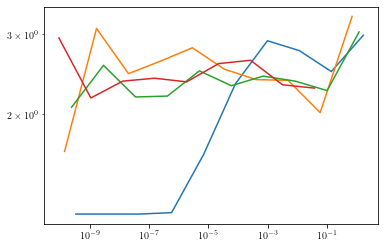

In [457]:
# Constraints for fiducial and non-fiducial models
fisher_lisa_step = Fisher_det(farr[mask_lisa], pars_step, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, distcorr=True)
cov_matrix_lisa_step = np.linalg.inv(fisher_lisa_step)

fisher_lisa_step_distcorr = Fisher_det(farr[mask_lisa], pars_step, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, distcorr=False)
cov_matrix_lisa_step_distcorr = np.linalg.inv(fisher_lisa_step_distcorr)

fisher_lisa_step_fid = Fisher_det(farr[mask_lisa], pars_step_fid, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, distcorr=True)
cov_matrix_lisa_step_fid = np.linalg.inv(fisher_lisa_step_fid)

fisher_lisa_step_fid_distcorr = Fisher_det(farr[mask_lisa], pars_step_fid, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, distcorr=False)
cov_matrix_lisa_step_fid_distcorr = np.linalg.inv(fisher_lisa_step_fid_distcorr)

pconstraints_lisa_step = np.sqrt(np.diag(cov_matrix_lisa_step))
pconstraints_lisa_step_fid = np.sqrt(np.diag(cov_matrix_lisa_step_fid))
pconstraints_lisa_step_distcorr = np.sqrt(np.diag(cov_matrix_lisa_step_distcorr))
pconstraints_lisa_step_fid_distcorr = np.sqrt(np.diag(cov_matrix_lisa_step_fid_distcorr))

print('LISA step function')
print('mod')
print(pconstraints_lisa_step)
print('mod with distcorr')
print(pconstraints_lisa_step_distcorr)
print('fiducial')
print(pconstraints_lisa_step_fid)
print('fiducial with dist corr')
print(pconstraints_lisa_step_fid_distcorr)


In [ ]:
# Now fix tc to ms accuracy
Fisher_matrix_lisa_step_fid = np.linalg.inv(cov_matrix_lisa_step_fid)
Fisher_matrix_lisa_step_fid_fixtc = np.array(Fisher_matrix_lisa_step_fid)
Fisher_matrix_lisa_step_fid_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fid_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fid_fixtc)

In [ ]:
# Now fix tc to ms accuracy
Fisher_matrix_lisa_step = np.linalg.inv(cov_matrix_lisa_step)
Fisher_matrix_lisa_step_fixtc = np.array(Fisher_matrix_lisa_step)
Fisher_matrix_lisa_step_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fixtc)

In [ ]:
# Same for uncorrected version
Fisher_matrix_lisa_step_fid_distcorr = np.linalg.inv(cov_matrix_lisa_step_fid_distcorr)
Fisher_matrix_lisa_step_fid_distcorr_fixtc = np.array(Fisher_matrix_lisa_step_fid_distcorr)
Fisher_matrix_lisa_step_fid_distcorr_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fid_distcorr_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fid_distcorr_fixtc)

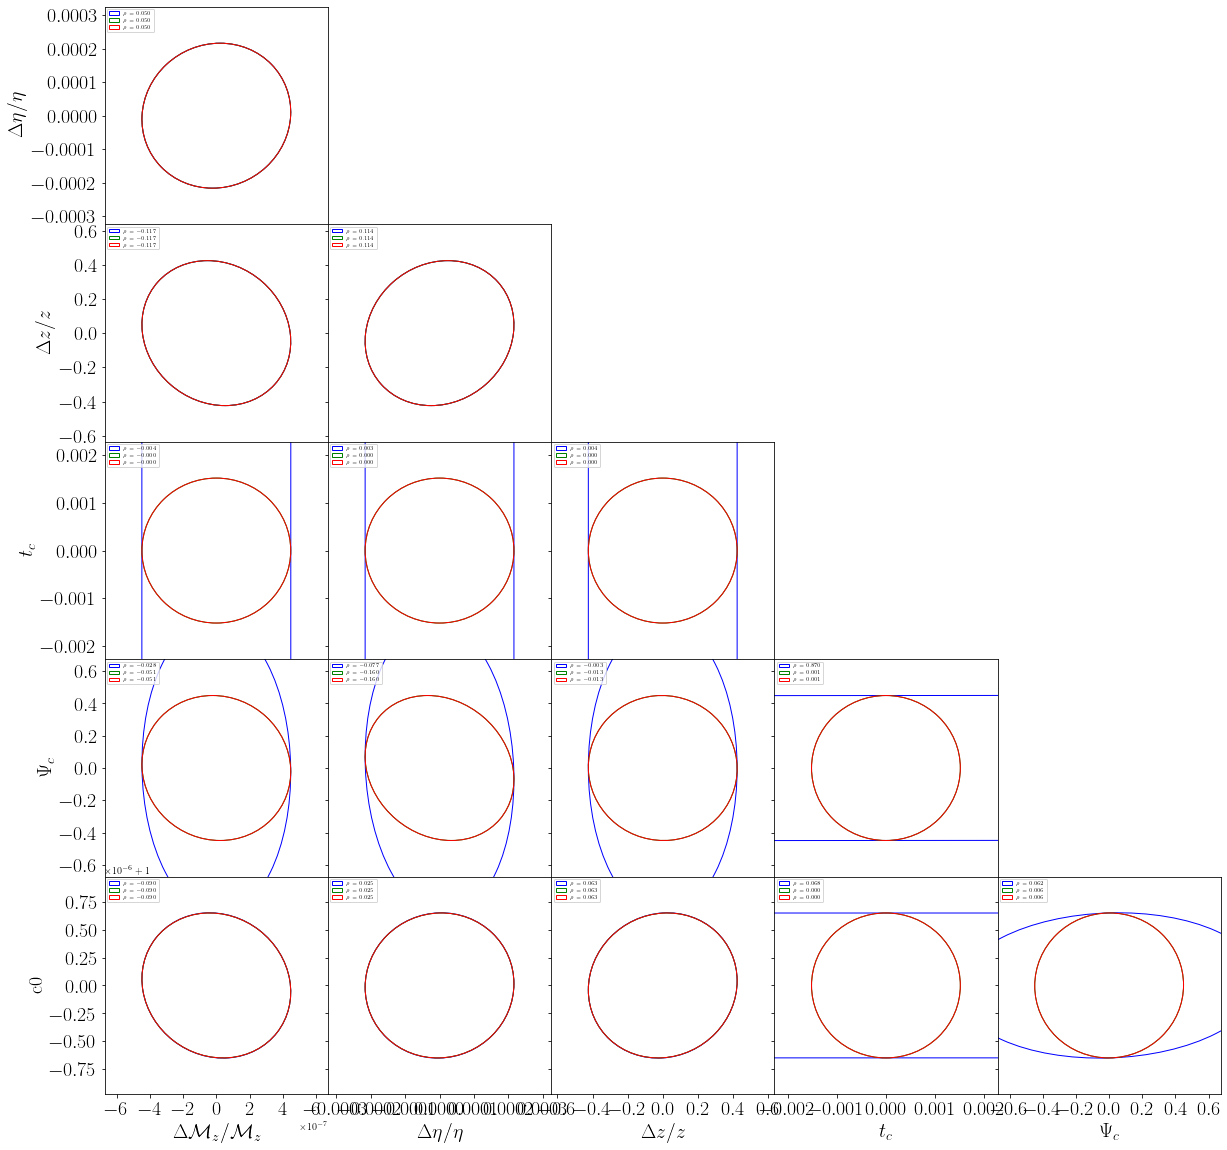

In [139]:
#make Fisher plot for LISA constraints with step fn
label = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$', 'c0']
fid_vals = [0,0,0,0,0,1]

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(len(fid_vals)-1, len(fid_vals)-1, hspace=0, wspace=0)

add_fisher_plots(cov_matrix_lisa_step_fid,fid_vals,label, 'vary tc',colour='b')
add_fisher_plots(cov_matrix_lisa_step_fid_fixtc,fid_vals,label,'fix tc',colour='g')
add_fisher_plots(cov_matrix_lisa_step_fid_distcorr_fixtc,fid_vals,label, 'fix tc no dist',colour='r')



In [151]:
label = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$', 'c0']
fid_vals = [0,0,0,0,0,1]
fid_vals_MG = [0,0,0,0,0,c0]

data = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid, size=20000)
data_fixtc = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_fixtc, size=20000)
data_distcorr = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_distcorr, size=20000)
data_distcorr_fixtc = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_distcorr_fixtc, size=20000)
data_MG = np.random.multivariate_normal(fid_vals_MG, cov_matrix_lisa_step, size=20000)
data_MG_fixtc = np.random.multivariate_normal(fid_vals_MG, cov_matrix_lisa_step_fixtc, size=20000)


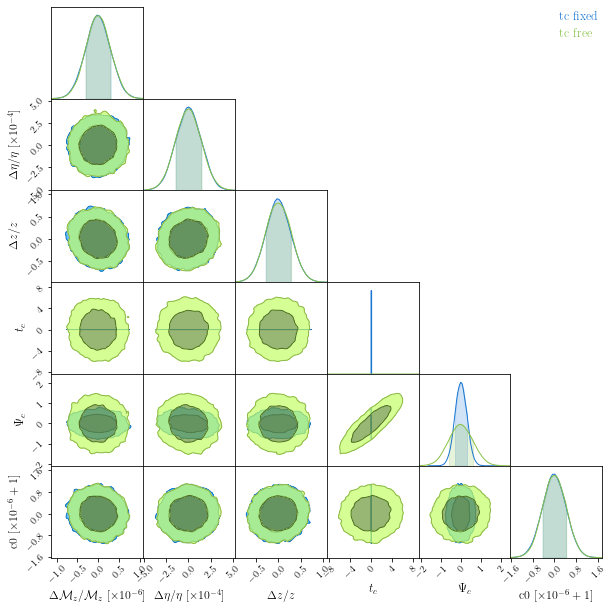

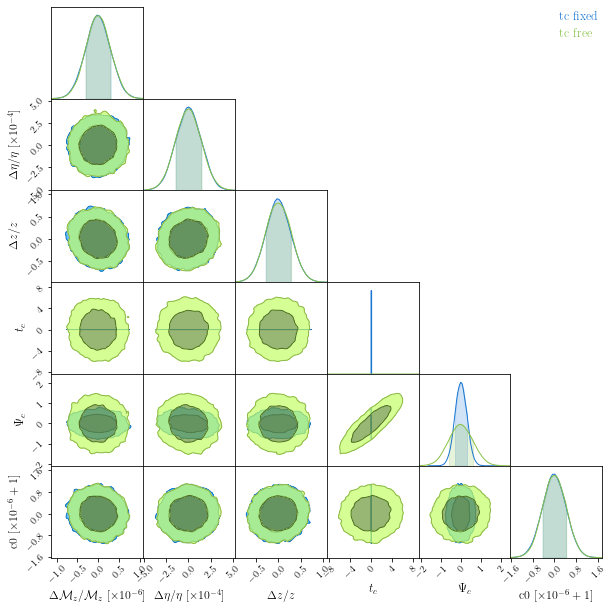

In [142]:
cc = ChainConsumer()
cc.add_chain(data_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed')
cc.add_chain(data, bins=30, smooth=True, parameters=label, name='tc free')
cc.plotter.plot()


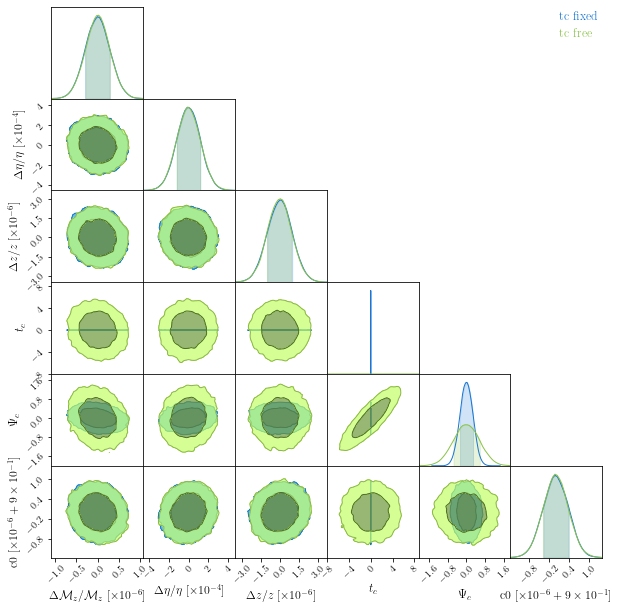

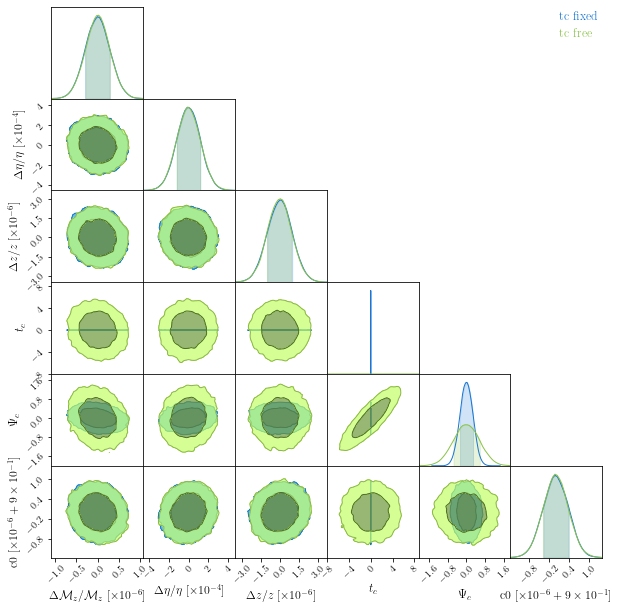

In [152]:
cc = ChainConsumer()
cc.add_chain(data_MG_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed')
cc.add_chain(data_MG, bins=30, smooth=True, parameters=label, name='tc free')
cc.plotter.plot()

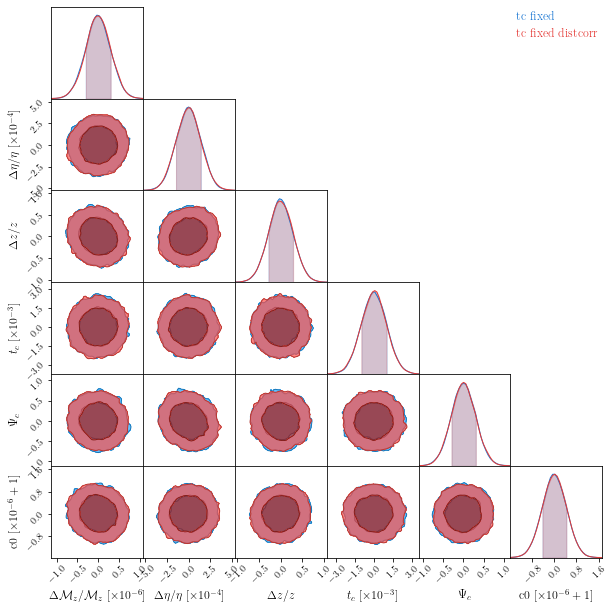

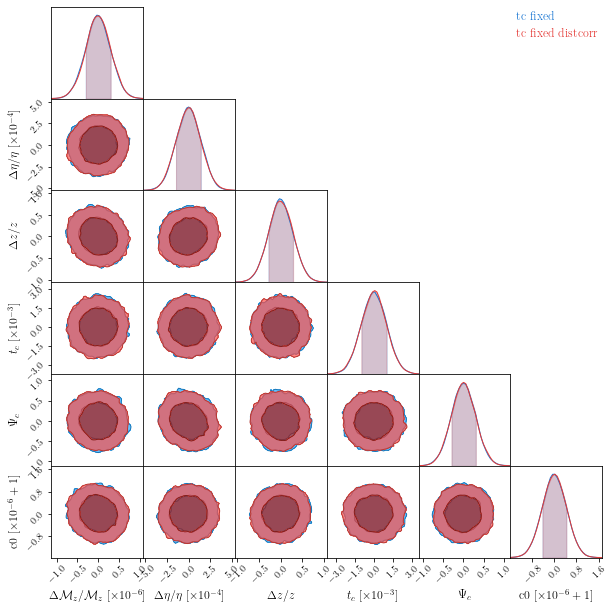

In [143]:
cc.remove_chain('tc free')

#cc.add_chain(data_fixtc, bins=30, smooth=True, parameters=label, name='tc fixed')
cc.add_chain(data_distcorr_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed distcorr',color='r')
cc.plotter.plot()

In [144]:
Psi, Psi_old = utilities.Psi_Delta_exact(farr, fstar, c0, Ms, eta, zem, cosmo_params, tc, psic, cT_type='step', width=w1)

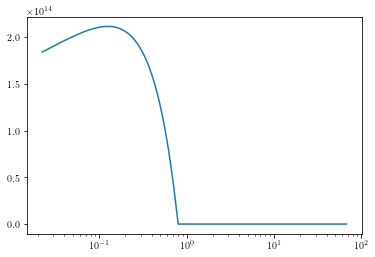

In [145]:
plt.semilogx(farr,abs(Psi/Psi_old))

In [127]:
cc.remove_chain('tc fixed')
cc.remove_chain('tc fixed distcorr')